In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json

## Cleaning Data

In [2]:
data = pd.read_csv('food-inspections.csv')
data.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,CHICAGO,IL,60606.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,CHICAGO,IL,60618.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,CHICAGO,IL,60622.0,...,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,CHICAGO,IL,60608.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [3]:
D = data.groupby("Zip")["Facility Type"].describe()
D

,count,unique,top,freq
Zip,,,,
10014.0,0,0,NaN,NaN
46319.0,1,1,Mobile Food Dispenser,1
53061.0,1,1,Shared Kitchen User (Long Term),1
60007.0,13,2,Mobile Food Dispenser,12
60015.0,2,1,PUSHCART,2
...,...,...,...,...
60714.0,7,1,Mobile Food Preparer,7
60803.0,3,1,Mobile Food Dispenser,3
60804.0,9,3,Mobile Food Dispenser,5


In [4]:
data['year']=data['Inspection Date'].apply(lambda x:x.split('-')[0]).astype(int)
data['month']=data['Inspection Date'].apply(lambda x:x.split('-')[1]).astype(int)
data['day']=data['Inspection Date'].apply(lambda x:x.split('-')[2].split('T')[0]).astype(int)

Let's consider only the dataset that contains non NA values for Longitude or Lagitude and we transform the Risk column into an int value column

In [5]:
loc= data[["Latitude","Longitude","AKA Name","Risk"]]
missing = loc[loc.isnull().any(axis = 1)]
data_removed = data.drop(missing.index)
data_removed = data_removed.reset_index()
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["Risk 3 (Low)", "Risk 2 (Medium)", "Risk 1 (High)","All"],  
                            value =[1,2,3,3]) 
data_removed.Risk = data_removed.Risk.astype(float)
data_removed["Risk"].value_counts()

3.0    139031
2.0     37402
1.0     16192
Name: Risk, dtype: int64

## Quick Risk overview

Looking at a quick study of the Risk we have the following Plots 

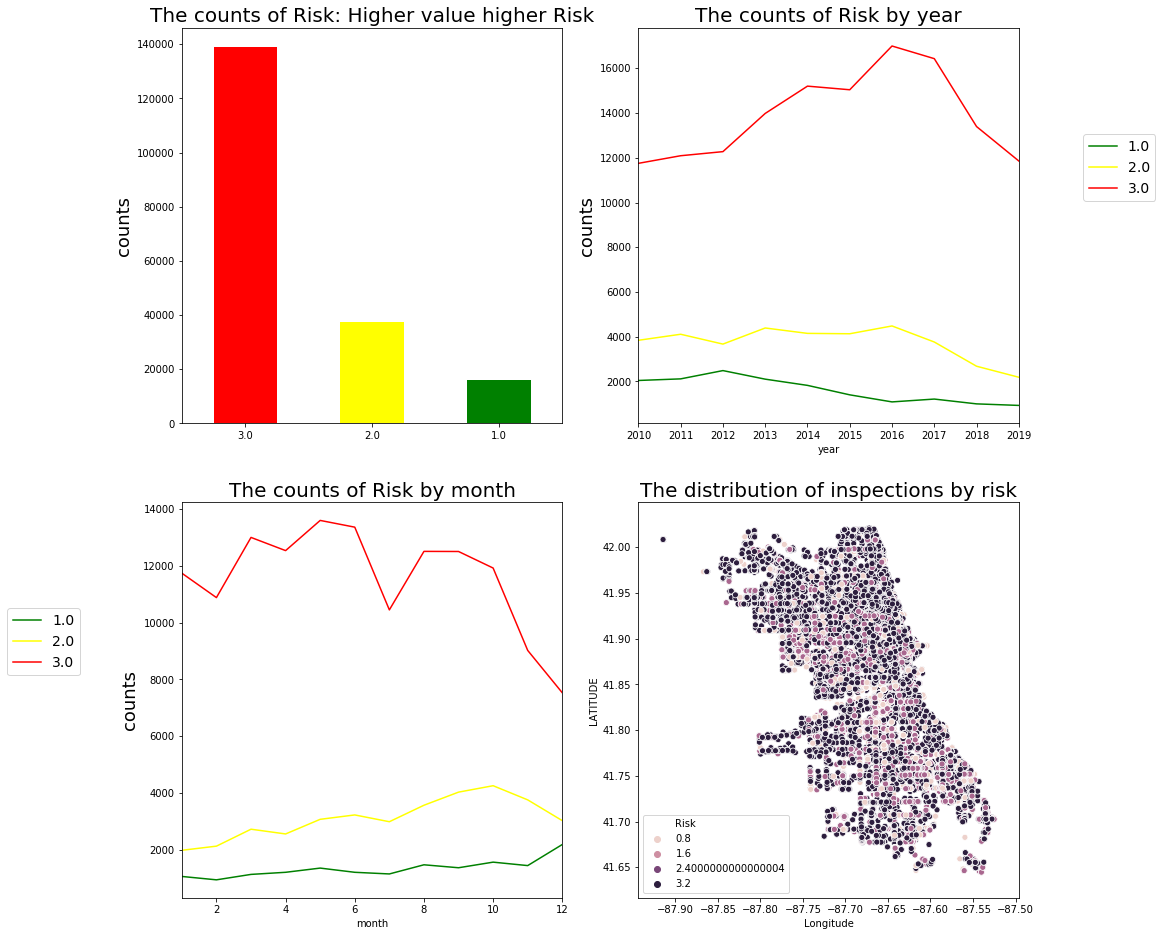

In [6]:
fig,ax=plt.subplots(2,2,figsize=(15,16))
data_removed.Risk.value_counts().plot(kind='bar',color=['red','yellow','green'],ax=ax[0,0])
ax[0,0].tick_params(axis='x',labelrotation=360)
ax[0,0].set_title("The counts of Risk: Higher value higher Risk",size=20)
ax[0,0].set_ylabel('counts',size=18)


data_removed.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax=ax[0,1],color=['green','yellow','red'])
ax[0,1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,0.75))
ax[0,1].set_title("The counts of Risk by year",size=20)
ax[0,1].set_ylabel('counts',size=18)

data_removed.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax=ax[1,0],color=['green','yellow','red'])
ax[1,0].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(-0.25,0.75))
ax[1,0].set_title("The counts of Risk by month",size=20)
ax[1,0].set_ylabel('counts',size=18)

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk' ,data=data_removed, ax=ax[1,1])
ax[1,1].set_title("The distribution of inspections by risk",size=20)
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('LATITUDE')
plt.show()

## Risk in function of the Zip codes

We now create a DataFrame containing all the data we want to plot in function of it Zip code hence we need to groupby zip and create features to our DataFrame

In [7]:
#Groupby ZIPS
zip_data = data_removed.groupby("Zip")
# Count number of failed exams
X = data_removed[data_removed['Results'] == 'Fail'].groupby('Zip')["Results"].count()
# Look for most frequent facility 
fac = zip_data["Facility Type"].describe()
#Add all features I can think of
mean_risk = zip_data.Risk.mean()
value_count = data_removed["Zip"].value_counts()
risk_map = pd.DataFrame(mean_risk)
risk_map["Count"] = value_count
risk_map["Fail"] = X
risk_map["Top Facility"] = fac.top.values
risk_map = risk_map.reset_index()
risk_map["Zip"] = risk_map["Zip"].astype(int)
risk_map = risk_map.fillna(0)
risk_map.head()

,Zip,Risk,Count,Fail,Top Facility
0,60148,3.00000,1,0.0,Shared Kitchen User (Long Term)
1,60406,3.00000,1,0.0,Shared Kitchen User (Long Term)
2,60501,1.25000,4,3.0,Mobile Food Dispenser
3,60559,1.00000,1,0.0,0
4,60601,2.71938,3225,403.0,Restaurant


In [8]:
j = 0
for i in range(0,len(data.loc[missing.index]["Zip"].unique())):
    if data.loc[missing.index]["Zip"].unique()[i] in risk_map["Zip"].values:
        j +=1
print("The number of missing Zip code when taking of restaurant that have either no location  or name is",
      len(data.loc[missing.index]["Zip"].unique())-j)

The number of missing Zip code when taking of restaurant that have either no location  or name is 49


We have that we do not have any restaurant in the 4 first data hence it make sense for now to drop those zips. Hence from the 109 Zips from the beggining we here work only with 60 of those which are mostly composed of restaurants

We know use Folium to have nice plots with the value of our table defined above

In [9]:
coord = [data_removed["Latitude"][0],data_removed["Longitude"][0]]
m= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)


In [10]:
# load GeoJSON
with open('Boundaries - ZIP Codes.geojson', 'r') as jsonFile:
    data_ = json.load(jsonFile)
tmp = data_

# remove ZIP codes not in our dataset
geozips = []
A=[]
for i in range(len(tmp['features'])):
    A.append(int((tmp['features'][i]['properties']['zip'])))
    if A[i] in (risk_map["Zip"].unique()):
        tmp['features'][i]['properties']['zip'] = int((tmp['features'][i]['properties']['zip']))
        geozips.append(tmp['features'][i])
        
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

5939874

We have created a JSON file containing all information needed for our ZIP code that are given in our data and that can be found also in Boundaries - ZIP Codes.geojson. We get a dataset with 61 entries, better to find one with more ZIP 

In [11]:
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = coord, tiles='cartodbpositron',zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.zip',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'BuPu',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' Number of facilites ' + add_text + ' Across Chigaco'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [12]:
create_map(risk_map, 'Zip', 'Risk', 'of Facilities')
create_map(risk_map, 'Zip', 'Count', 'of Facilities')
create_map(risk_map, 'Zip', 'Fail', 'of Facilities')


C:\Users\marco\Desktop\Python\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [13]:
def coloriage(zip_):
    if risk_map.loc[risk_map['Zip'] == zip_, 'Top Facility'].values[0]=="Restaurant":
        return '#0000ff'
    else:
        return '#ff0000'
    

In [14]:
state_geo_path = r"updated-file.json"
geo_json_data = json.load(open(state_geo_path))
results_map = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda features: {
        'fillColor': coloriage(features["properties"]["zip"]),
        'color' : 'black',
        'weight' : 3,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)



We can see that there is only a district in the far border near Dolton which is composed mostly of Schools


Now Let's look at the HeatMap folium function found on the folium Package

In [15]:
def generateBaseMap(default_location=coord, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [16]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map.save("Heatmap of facilities")

## Working in function of the Years

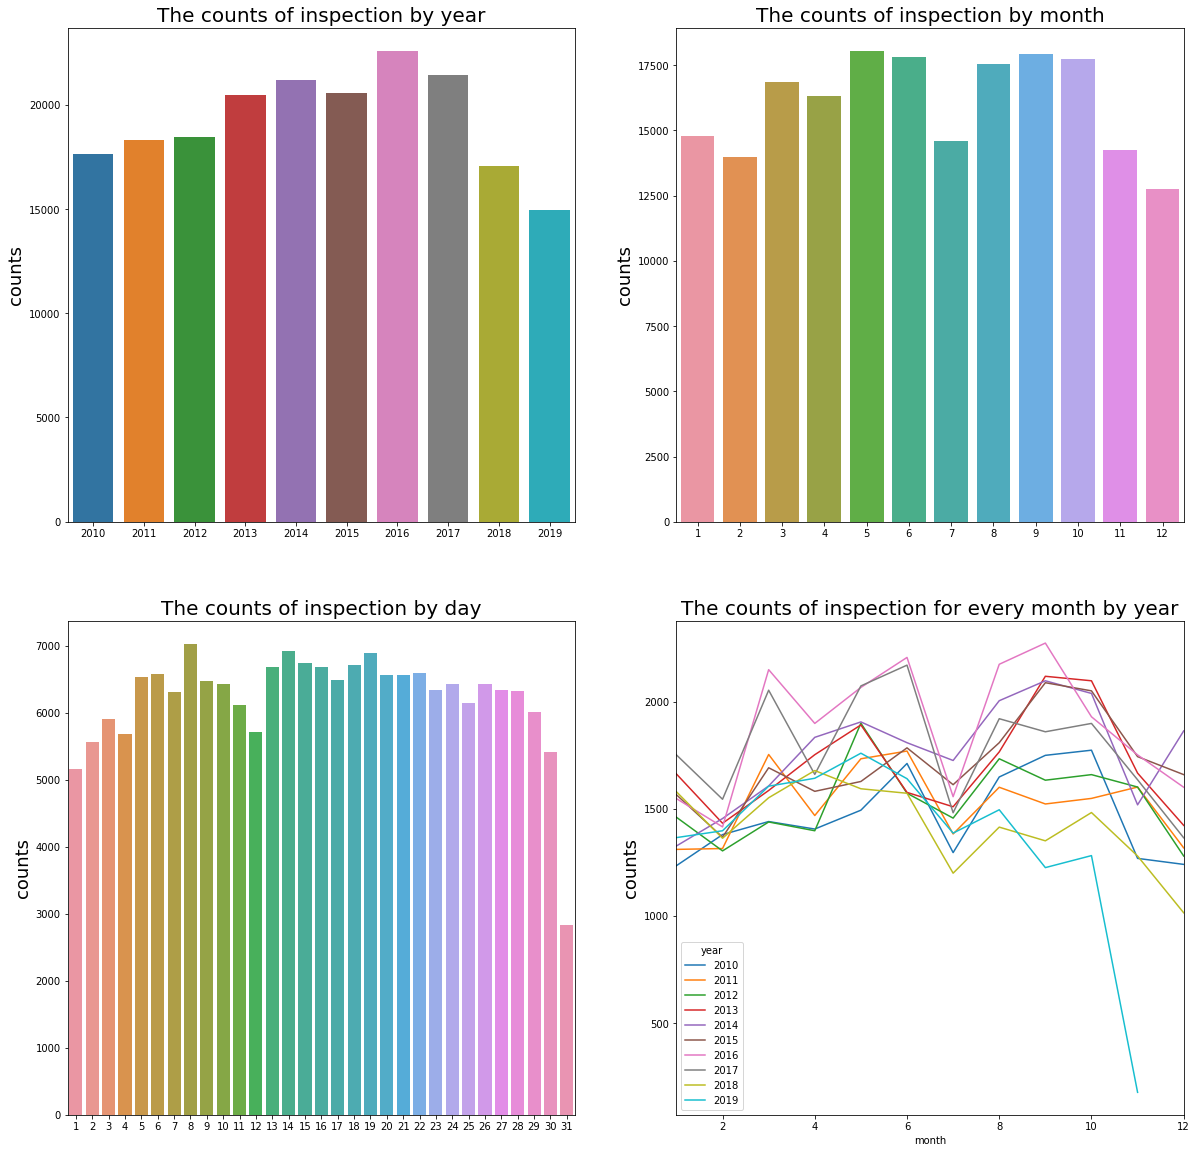

In [17]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
x=data_removed.year.value_counts().index
y=data_removed.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("The counts of inspection by year",size=20)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

x=data_removed.month.value_counts().index
y=data_removed.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,1])
ax[0,1].set_title("The counts of inspection by month",size=20)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('')

x=data_removed.day.value_counts().index
y=data_removed.day.value_counts()
sns.barplot(x=x,y=y,ax=ax[1,0])
ax[1,0].set_title("The counts of inspection by day",size=20)
ax[1,0].set_ylabel('counts',size=18)
ax[1,0].set_xlabel('')

data_removed.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("The counts of inspection for every month by year",size=20)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('month')
plt.show()

## Looking at a restaurant based Analysis 

In [18]:
def generateBaseMap(default_location=coord, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [19]:
name_data = data_removed.groupby(["AKA Name","Latitude","Longitude","year"])
name_count = name_data["DBA Name"].count()
name_map = pd.DataFrame(name_count)
name_map = name_map.rename(columns={"DBA Name": "Count"})
name_map = name_map.reset_index()
name_map.head()

,AKA Name,Latitude,Longitude,year,Count
0,"#1 CHINA EXPRESS , LTD",41.816834,-87.631346,2010,1
1,"#1 CHINA EXPRESS , LTD",41.816834,-87.631346,2012,1
2,#1 CHOP SUEY,41.735578,-87.670781,2010,3
3,#1 CHOP SUEY,41.735578,-87.670781,2011,1
4,#1 CHOP SUEY,41.735578,-87.670781,2013,2


In [20]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[["Latitude","Longitude"]].groupby(["Latitude","Longitude"]).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

In [21]:
year_list = []
for year in data_removed.year.sort_values().unique():
    year_list.append(name_map.loc[name_map.year == year, ["Latitude","Longitude","Count"]])

In [22]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(year_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

In [23]:
len(data_removed)

192625

In [24]:
year_list


[         Latitude  Longitude  Count
 0       41.816834 -87.631346      1
 2       41.735578 -87.670781      3
 18      41.953443 -87.735763      1
 30      41.799626 -87.591374      2
 38      41.924965 -87.692401      1
 ...           ...        ...    ...
 116427  41.763519 -87.602081      1
 116435  41.998121 -87.688822      2
 116442  41.750932 -87.683018      1
 116443  41.745778 -87.663176      1
 116447  41.938443 -87.768318      2
 
 [10424 rows x 3 columns],          Latitude  Longitude  Count
 3       41.735578 -87.670781      1
 19      41.953443 -87.735763      2
 28      41.953443 -87.735763      1
 31      41.799626 -87.591374      8
 39      41.924965 -87.692401      1
 ...           ...        ...    ...
 116397  42.002726 -87.660938      1
 116426  41.961514 -87.708405      1
 116428  41.763519 -87.602081      2
 116438  41.747482 -87.604984      1
 116449  41.885137 -87.633766      2
 
 [10762 rows x 3 columns],          Latitude  Longitude  Count
 1       41.816834 

In [30]:
folium.__version__


'0.10.0'

## Useless for now

In [25]:
state_geo_path = r"updated-file.json"
geo_json_data = json.load(open(state_geo_path))
m_usa = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(geo_json_data).add_to(m_usa)
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=risk_map,
    columns=['Zip', 'Risk'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Risk given to restaurant'
    
).add_to(m_usa)
folium.LayerControl().add_to(m_usa)
m_usa.save('Marco.html')


In [26]:
fac = (data['Facility Type'].value_counts())
print("The possible results for each facilites are the follwoing with the results given by:")
display(data['Results'].value_counts())

The possible results for each facilites are the follwoing with the results given by:


Pass                    105795
Fail                     37870
Pass w/ Conditions       27105
Out of Business          16844
No Entry                  6237
Not Ready                 1877
Business Not Located        68
Name: Results, dtype: int64

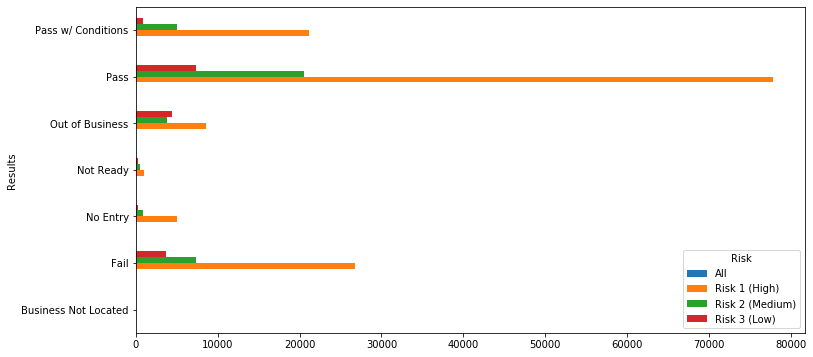

In [27]:
facility = data.groupby("Risk")
facility['Results'].value_counts().unstack(0).plot.barh(figsize=(12,6))
plt.show()